<a href="https://colab.research.google.com/github/ngonhan2k5/cs-ml/blob/master/proj3/notebook/vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os.path
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

# **1. Settings**

In [ ]:
NUM_CLASSES= 2
MODEL_FILEPATH= '/content/gdrive/My Drive/ML_Machine_Learning/model/vgg16_model.h5'

train_path = '/content/gdrive/My Drive/ML_Machine_Learning/data/cats-and-dogs/train'
valid_path = '/content/gdrive/My Drive/ML_Machine_Learning/data/cats-and-dogs/valid'
test_path = '/content/gdrive/My Drive/ML_Machine_Learning/data/cats-and-dogs/test'

#**2. Data preparation**

The images included in the data/cats-and-dogs directory are a random subset of the full cat and dog data set from the following Kaggle competition:
https://www.kaggle.com/c/dogs-vs-cats/data

In [ ]:
train_batches = ImageDataGenerator().flow_from_directory(directory=train_path, target_size=(224,224), classes=['dog', 'cat'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(directory=valid_path, target_size=(224,224), classes=['dog', 'cat'], batch_size=4)
test_batches = ImageDataGenerator().flow_from_directory(directory=test_path, target_size=(224,224), classes=['dog', 'cat'], batch_size=10)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [ ]:
# assert train_batches.n == 40
# assert valid_batches.n == 16
# assert test_batches.n == 10
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == NUM_CLASSES

In [ ]:
# plots images with labels within jupyter notebook
# source: https://github.com/fastai/courses/blob/master/deeplearning1/nbs/utils.py#L79

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

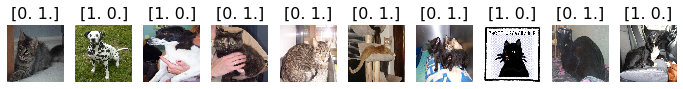

In [ ]:
imgs, labels = next(train_batches)
plots(imgs, titles=labels)

# **3. VGG16**

##3.1. Build Model
- Transfer Learning
- Save the builded model for the next time using

In [ ]:
def build_model(base_model):
  model = Sequential()
  for layer in vgg_model.layers[:-1]: #loop until the last layer (exclude the output-predictions layer)
    model.add(layer)
  #freeze model
  for layer in model.layers:
    layer.trainable = False 
    
  #add prediction layers
  model.add(Dense(units=NUM_CLASSES, activation='softmax'))
  return model

In [ ]:
if os.path.isfile(MODEL_FILEPATH) is True:
  model= load_model(MODEL_FILEPATH)
else:  
  # Download VGG16 model - Internet connection needed
  vgg_model = tf.keras.applications.vgg16.VGG16()

  # Transfer learning VGG16 model
  model= build_model(vgg_model)
  model.summary()

  #Compile model
  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

  # Save model
  if os.path.isfile(MODEL_FILEPATH) is False:
    model.save(MODEL_FILEPATH)

553467904/553467096 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_______________________________________________________

##3.2. Train model

In [ ]:
history = model.fit(x=train_batches, steps_per_epoch=4, 
                    validation_data=valid_batches, validation_steps=4, epochs=10, verbose=2)

Epoch 1/10
4/4 - 29s - loss: 1.4164 - accuracy: 0.4750 - val_loss: 0.4673 - val_accuracy: 0.7500
Epoch 2/10
4/4 - 30s - loss: 0.6540 - accuracy: 0.6500 - val_loss: 0.6446 - val_accuracy: 0.6250
Epoch 3/10
4/4 - 29s - loss: 0.6789 - accuracy: 0.6250 - val_loss: 0.4729 - val_accuracy: 0.7500
Epoch 4/10
4/4 - 30s - loss: 0.6601 - accuracy: 0.7250 - val_loss: 0.3721 - val_accuracy: 0.9375
Epoch 5/10
4/4 - 26s - loss: 0.7191 - accuracy: 0.6750 - val_loss: 0.4240 - val_accuracy: 0.8125
Epoch 6/10
4/4 - 30s - loss: 0.4827 - accuracy: 0.8250 - val_loss: 0.6181 - val_accuracy: 0.7500
Epoch 7/10
4/4 - 26s - loss: 0.2159 - accuracy: 0.9000 - val_loss: 0.1300 - val_accuracy: 0.9375
Epoch 8/10
4/4 - 22s - loss: 0.3311 - accuracy: 0.8250 - val_loss: 0.4231 - val_accuracy: 0.7500
Epoch 9/10
4/4 - 16s - loss: 0.1973 - accuracy: 0.9750 - val_loss: 0.0808 - val_accuracy: 1.0000
Epoch 10/10
4/4 - 19s - loss: 0.2765 - accuracy: 0.8750 - val_loss: 0.2755 - val_accuracy: 0.9375


In [ ]:
assert model.history.history.get('accuracy')[-1] > 0.85

##3.3. Predict

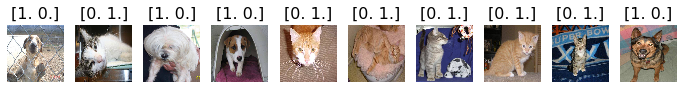

In [ ]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [ ]:
test_labels = test_labels[:,0]
test_labels

array([1., 0., 1., 1., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [ ]:
predicted_labels = model.predict(x=test_batches, steps=1, verbose=0)

**Confusion matrix**

In [ ]:
cm = confusion_matrix(y_true=test_labels, y_pred=np.round(predicted_labels[:,0]))

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[6 0]
 [0 4]]


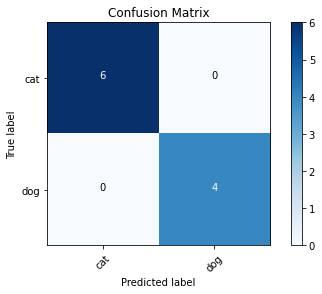

In [ ]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
def print_results(cm):
    tp = cm[0, 0]
    tn = cm[1, 1]
    fn = cm[0, 1]
    fp = cm[1, 0]
    
    accuracy = ((tp + tn) / (tp + tn + fp + fn)) * 100    
    sensitivity = (tp / (tp + fn)) * 100    
    specificity = (tn / ( tn + fp )) * 100
    
    precision= tp / (tp+fp) 
    recall= tp / (tp+fn)
    f1= (2 * precision * recall) / (precision + recall) 

    print ('Accuracy   : ',  accuracy, "%")
    print ('Sensitivity: ', sensitivity, "%")    
    print ('Specificity: ',  specificity, "%")
    print ('')
    print ('F1 score   : ',  round(f1 * 100, 1), "%")
    print ('Precision  : ', round(precision * 100, 1), "%")    
    print ('Recall     : ',  round(recall * 100, 1), "%")

In [ ]:
print_results(cm)

Accuracy   :  100.0 %
Sensitivity:  100.0 %
Specificity:  100.0 %

F1 score   :  100.0 %
Precision  :  100.0 %
Recall     :  100.0 %


##3.4. Loss Curve and Accuracy Curve

In [ ]:
def plot_training_curves(history):  
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss,  label='Train')
    plt.plot(epochs, val_loss, label='Test')
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.figure()
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.plot(epochs, acc, label='Train')
    plt.plot(epochs, val_acc, label='Test')
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch') 
    plt.legend()
    plt.figure()
    
    plt.show()

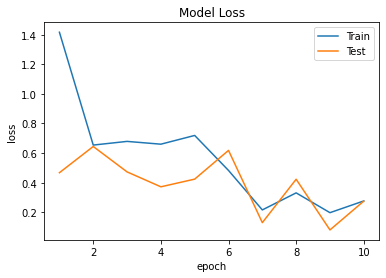

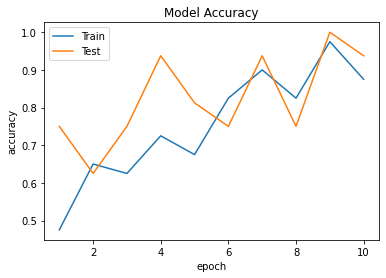

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_training_curves(history)